In [87]:
import os
import random
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Checking if it is usefull
# import logging


In [88]:

# logging.basicConfig(level=logging.INFO)
# logging.info("Dataset loading started.")

In [89]:
# Define directories
train_dir = './train'  # train directory
valid_dir = './valid'  # validation directory
test_dir = './test'    # test directory


In [90]:
# loading datasets and preprocessing images.
def load_and_preprocess_images(directory, img_size=(32, 32)):
    data = []
    labels = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Ensure it's a directory
            print(f"Loading data from class '{class_name}'...")
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    img = img / 255.0  # Normalize pixel values
                    data.append(img)
                    labels.append(class_name)
    return np.array(data), np.array(labels)


In [91]:
# Convert class names into numerical labels using LabelEncoder

def encode_labels(labels):
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    return labels_encoded, label_encoder

In [92]:
# 
def create_generators(train_dir, valid_dir, test_dir, img_size=(32, 32), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    valid_gen = datagen.flow_from_directory(
        valid_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    test_gen = datagen.flow_from_directory(
        test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    
    return train_gen, valid_gen, test_gen

In [93]:
# Validate directory structure
def validate_directory_structure(directories):
    for dir_path in directories:
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Directory '{dir_path}' does not exist!")
        for class_name in os.listdir(dir_path):
            class_dir = os.path.join(dir_path, class_name)
            if not os.path.isdir(class_dir):
                raise ValueError(f"'{class_name}' in '{dir_path}' is not a directory!")
    print("Directory structure validated!")


In [94]:
# Use multiprocessing to speed up dataset loading using concurrent.future if there are a lot of images.
def load_image(img_path, img_size):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, img_size)
        return img / 255.0
    return None



In [95]:
def load_dataset_with_threads(directory, img_size=(32, 32)):
    data = []
    labels = []
    with ThreadPoolExecutor() as executor:
        for class_name in os.listdir(directory):
            class_dir = os.path.join(directory, class_name)
            if os.path.isdir(class_dir):
                print(f"Loading data from class '{class_name}'...")
                image_paths = [os.path.join(class_dir, filename) for filename in os.listdir(class_dir)]
                images = list(executor.map(lambda path: load_image(path, img_size), image_paths))
                data.extend([img for img in images if img is not None])
                labels.extend([class_name] * len(images))
    return np.array(data), np.array(labels)

In [96]:
def plot_class_distribution(labels, title="Class Distribution"):
    import seaborn as sns
    sns.countplot(x=labels)
    plt.title(title)
    plt.show()


In [97]:
def display_random_sample(dataset_dir, img_size=(32, 32)):
    classes = os.listdir(dataset_dir)  # List of class directories
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)
        random_image = random.choice(image_files)
        img_path = os.path.join(class_dir, random_image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color for proper visualization
        plt.subplot(1, len(classes), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{class_name} ({img.shape[1]}x{img.shape[0]})")
    plt.show()

In [98]:
#train_dir = './train'
#valid_dir = './valid'
#test_dir = './test'

# Load data
#x_train, y_train = load_dataset_with_threads(train_dir, img_size=(32, 32))
#x_valid, y_valid = load_dataset_with_threads(valid_dir, img_size=(32, 32))
#x_test, y_test = load_dataset_with_threads(test_dir, img_size=(32, 32))

# Encode labels
#y_train, label_encoder = encode_labels(y_train)
#y_valid, _ = encode_labels(y_valid)
#y_test, _ = encode_labels(y_test)

# Print data shapes
#print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
#print(f"x_valid: {x_valid.shape}, y_valid: {y_valid.shape}")
#print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")




Directory structure validated!
Loading data from class 'nowildfire'...
Loading data from class 'wildfire'...
Loading data from class 'nowildfire'...
Loading data from class 'wildfire'...
Loading data from class 'nowildfire'...
Loading data from class 'wildfire'...
x_train shape: (30250, 32, 32, 3), y_train shape: (30250, 2)
x_valid shape: (6300, 32, 32, 3), y_valid shape: (6300, 2)
x_test shape: (6300, 32, 32, 3), y_test shape: (6300, 2)
Classes: ['nowildfire' 'wildfire']
Random samples from the training set:


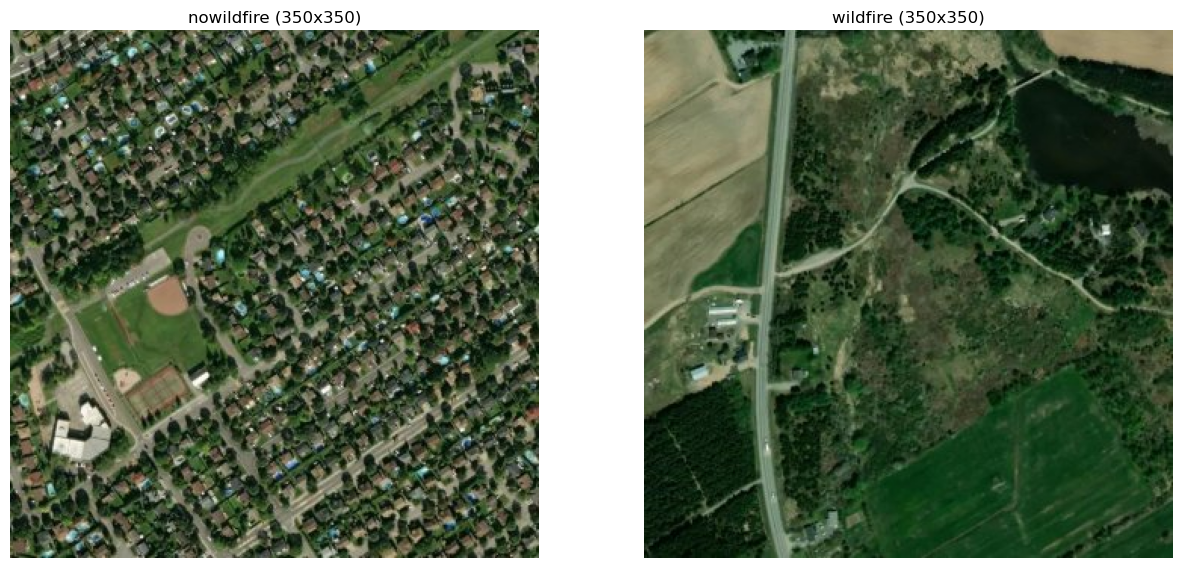

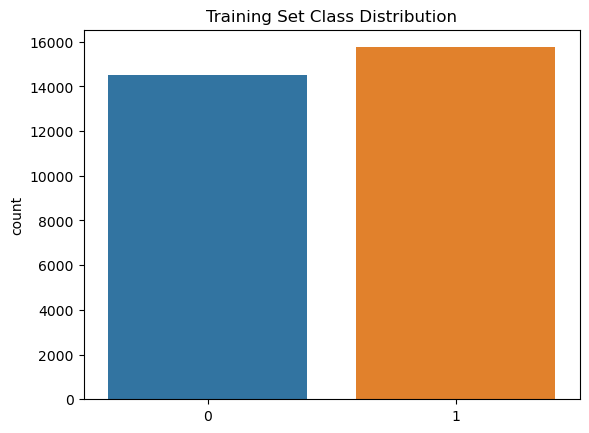

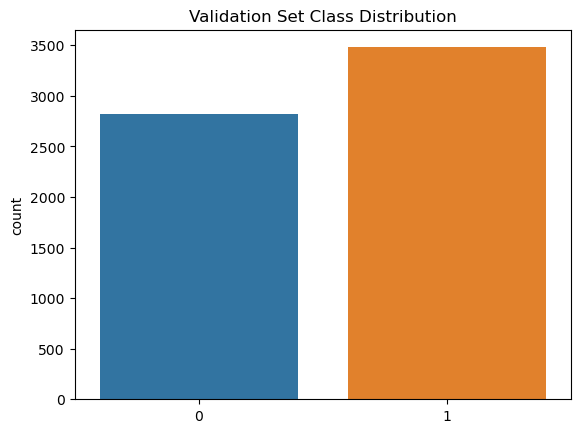

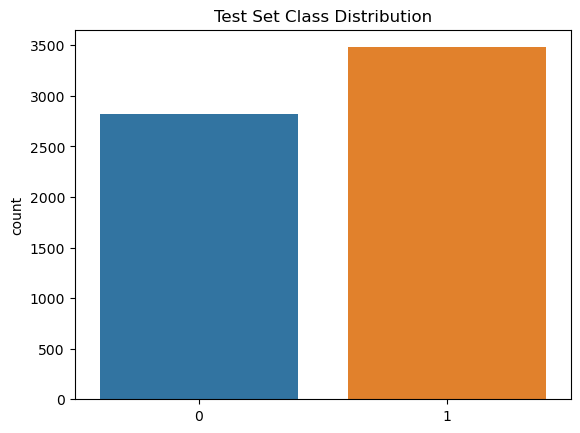

In [99]:
# Validate directory structure
validate_directory_structure([train_dir, valid_dir, test_dir])

# Load datasets
x_train, y_train = load_and_preprocess_images(train_dir)
x_valid, y_valid = load_and_preprocess_images(valid_dir)
x_test, y_test = load_and_preprocess_images(test_dir)

# Encode labels
y_train, label_encoder = encode_labels(y_train)
y_valid, _ = encode_labels(y_valid)
y_test, _ = encode_labels(y_test)

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_valid = to_categorical(y_valid, num_classes)
y_test = to_categorical(y_test, num_classes)

# Display dataset info
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"Classes: {label_encoder.classes_}")

# Display random samples
print("Random samples from the training set:")
display_random_sample(train_dir)

# Plot class distribution
# Bar plots showing the number of samples per class for training, validation, and test sets.
plot_class_distribution(y_train.argmax(axis=1), title="Training Set Class Distribution")
plot_class_distribution(y_valid.argmax(axis=1), title="Validation Set Class Distribution")
plot_class_distribution(y_test.argmax(axis=1), title="Test Set Class Distribution")

In [100]:
# CNN Model Building
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Second convolutional block
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Third convolutional block
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [101]:
input_shape = x_train.shape[1:]  # (32, 32, 3) for RGB images
cnn_model = build_cnn_model(input_shape, num_classes)

C:\Users\malhe\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [102]:
# Model summary
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,778 (1.36 MB)

 Trainable params: 355,778 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [104]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [105]:
# Fit the model
history = cnn_model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=len(x_train) // 32,
    epochs=10,
    validation_data=valid_datagen.flow(x_valid, y_valid),
    validation_steps=len(x_valid) // 32
)

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/10


C:\Users\malhe\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


945/945 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.7295 - loss: 0.5013 - val_accuracy: 0.8683 - val_loss: 0.3241
Epoch 2/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - accuracy: 0.9062 - loss: 0.3188 - val_accuracy: 1.0000 - val_loss: 0.1460
Epoch 3/10
  4/945 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.8809 - loss: 0.3861

C:\Users\malhe\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


945/945 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.8529 - loss: 0.3605 - val_accuracy: 0.8862 - val_loss: 0.2945
Epoch 4/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.8750 - loss: 0.3399 - val_accuracy: 0.8929 - val_loss: 0.3760
Epoch 5/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.8533 - loss: 0.3507 - val_accuracy: 0.8681 - val_loss: 0.3231
Epoch 6/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 28us/step - accuracy: 0.8438 - loss: 0.4138 - val_accuracy: 0.8929 - val_loss: 0.2808
Epoch 7/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8629 - loss: 0.3340 - val_accuracy: 0.8900 - val_loss: 0.2948
Epoch 8/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 31us/step - accuracy: 0.8750 - loss: 0.3653 - val_accuracy: 0.9286 - val_loss: 0.1886
Epoch 9/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.8615 - loss: 0.3354 - val_accuracy: 0.8932 - val_loss: 0.2801
Epoch 10/10
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.8750 - loss: 0.2834 - val_accuracy: 